## Final Project: Predict a student's GPA using Dartmouth's Student Life Education Dataset
Heather R. Sanders

CSC 570: Data Science

Mike Bernico

May 13, 2016

### Data:

Class, courses each student is taking

Deadline, number of deadlines each student has each day

Grades, each students cumulative, Spring '13, and CSC 65 gpa

Piazza, student accessing LMS

In [140]:
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
# The error metric. In this case, we will use c-stat (aka ROC/AUC)
from sklearn.metrics import roc_auc_score
%matplotlib inline

In [53]:
# Read Education csv data from Dartmouth's Student Life Dataset
edClass_df = pd.read_csv("/home/heather/Documents/Graduate_School/CSC570_DataScience/FinalProject/dataset/dataset/education/class.csv")
edDead_df = pd.read_csv("/home/heather/Documents/Graduate_School/CSC570_DataScience/FinalProject/dataset/dataset/education/deadlines.csv")
edGrades_df = pd.read_csv("/home/heather/Documents/Graduate_School/CSC570_DataScience/FinalProject/dataset/dataset/education/grades.csv")
edPiazza_df = pd.read_csv("/home/heather/Documents/Graduate_School/CSC570_DataScience/FinalProject/dataset/dataset/education/piazza.csv")

### Look at Education data columns, shape, describe and head

In [54]:
# edClass_df lists each student and the courses they are taking
edClass_df.columns

Index([u'uid', u'course1', u'course2', u'course3', u'course4'], dtype='object')

In [55]:
edClass_df.shape

(49, 5)

In [56]:
edClass_df.describe()

,uid,course1,course2,course3,course4
count,49,49,49,49,49
unique,49,24,21,11,2
top,u16,COSC 070,COSC 065,na,na
freq,1,9,19,21,46


In [57]:
# List all classes students are taking
pd.unique(edClass_df[['course1','course2','course3','course4']].values.ravel())

array(['na', 'ENGS 069', 'ENGS 022', 'ANTH 012', 'COSC 077', 'COSC 098',
       'COSC 065', 'COSC 057', 'COSC 050', 'PSYC 028', 'COSC 060',
       'CHIN 062', 'COSC 089 1', 'ANTH 050', 'COSC 099', 'BIOL 004',
       'TUCK 003', 'COSC 070', 'COSC 027', 'COSC 020', 'EARS 003',
       'SPAN 003', 'MUS 016', 'CHIN 033', 'FILM 051', 'NAS 035',
       'M&SS 045', 'NAS 008', 'ENGL 028', 'ECON 024', 'JAPN 033',
       'FILM 042', 'MUS 003', 'MATH 023', 'COSC 069', 'ENGS 025',
       'ENGS 093', 'SPAN 002', 'ENGS 031', 'ECON 036', 'MATH 013',
       'LAT 003', 'BIOL 006', 'GERM 001', 'COSC 007'], dtype=object)

In [58]:
# Convert classes to dummies
class_Series = pd.get_dummies(edClass_df[['course1','course2','course3','course4']].apply(pd.Series).stack()).sum(level=0)

In [59]:
class_Series.shape

(49, 45)

In [60]:
edClass_df.head(5)

,uid,course1,course2,course3,course4
0,u00,na,na,na,na
1,u01,ENGS 069,ENGS 022,ANTH 012,na
2,u02,COSC 077,COSC 098,COSC 065,na
3,u03,COSC 057,COSC 065,na,na
4,u04,COSC 065,na,na,na


In [61]:
# Merge Class uid with class_Series
uID = edClass_df[['uid']]

In [62]:
class_df=pd.concat([uID, class_Series], axis=1)

In [63]:
class_df.shape

(49, 46)

In [65]:
class_df.head(5)

,uid,ANTH 012,ANTH 050,BIOL 004,BIOL 006,CHIN 033,CHIN 062,COSC 007,COSC 020,COSC 027,...,MATH 023,MUS 003,MUS 016,NAS 008,NAS 035,PSYC 028,SPAN 002,SPAN 003,TUCK 003,na
0,u00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
1,u01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,u02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,u03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,u04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0


In [7]:
# edDead_df lists each students number of class deadlines per day
edDead_df.columns

Index([u'uid', u'2013-03-27', u'2013-03-28', u'2013-03-29', u'2013-03-30',
       u'2013-03-31', u'2013-04-01', u'2013-04-02', u'2013-04-03',
       u'2013-04-04',
       ...
       u'2013-08-10', u'2013-08-11', u'2013-08-12', u'2013-08-13',
       u'2013-08-14', u'2013-08-15', u'2013-08-16', u'2013-08-17',
       u'2013-08-18', u'2013-08-19'],
      dtype='object', length=147)

In [14]:
edDead_df.shape

(44, 147)

In [17]:
edDead_df.describe()

,2013-03-27,2013-03-28,2013-03-29,2013-03-30,2013-03-31,2013-04-01,2013-04-02,2013-04-03,2013-04-04,2013-04-05,...,2013-08-10,2013-08-11,2013-08-12,2013-08-13,2013-08-14,2013-08-15,2013-08-16,2013-08-17,2013-08-18,2013-08-19
count,44.000000,44.000000,44.000000,44.0,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,0.068182,0.068182,0.136364,0.0,0.204545,0.250000,0.340909,0.113636,0.022727,0.181818,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,0.333949,0.254972,0.408680,0.0,0.408032,0.533745,0.525763,0.442819,0.150756,0.495220,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,2.000000,1.000000,2.000000,0.0,1.000000,2.000000,2.000000,2.000000,1.000000,2.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
edDead_df.head(5)

,uid,2013-03-27,2013-03-28,2013-03-29,2013-03-30,2013-03-31,2013-04-01,2013-04-02,2013-04-03,2013-04-04,...,2013-08-10,2013-08-11,2013-08-12,2013-08-13,2013-08-14,2013-08-15,2013-08-16,2013-08-17,2013-08-18,2013-08-19
0,u01,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,u02,0,0,0,0,0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,u03,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,u04,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,u05,0,0,0,0,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
# Determine number of NaN
edDead_df.isnull().sum()

uid            0
2013-03-27     0
2013-03-28     0
2013-03-29     0
2013-03-30     0
2013-03-31     0
2013-04-01     0
2013-04-02     0
2013-04-03     0
2013-04-04     0
2013-04-05     0
2013-04-06     0
2013-04-07     0
2013-04-08     0
2013-04-09     0
2013-04-10     0
2013-04-11     0
2013-04-12     0
2013-04-13     0
2013-04-14     0
2013-04-15     0
2013-04-16     0
2013-04-17     0
2013-04-18     0
2013-04-19     0
2013-04-20     0
2013-04-21     0
2013-04-22     0
2013-04-23     0
2013-04-24     0
              ..
2013-07-21    44
2013-07-22    44
2013-07-23    44
2013-07-24    44
2013-07-25    44
2013-07-26    44
2013-07-27    44
2013-07-28    44
2013-07-29    44
2013-07-30    44
2013-07-31    44
2013-08-01    44
2013-08-02    44
2013-08-03    44
2013-08-04    44
2013-08-05    44
2013-08-06    44
2013-08-07    44
2013-08-08    44
2013-08-09    44
2013-08-10    44
2013-08-11    44
2013-08-12    44
2013-08-13    44
2013-08-14    44
2013-08-15    44
2013-08-16    44
2013-08-17    

In [67]:
# Everything after 2013-06-06 is empty, delete those columns
deadline_df = edDead_df.ix[:,:'2013-06-05']

In [68]:
deadline_df.shape

(44, 72)

In [9]:
# edGrades_df lists each students cumulated GPA, 2013 Spring term GPA and grades for COSC 065
edGrades_df.columns

Index([u'uid', u' gpa all', u' gpa 13s', u' cs 65'], dtype='object')

In [18]:
edGrades_df.shape

(30, 4)

In [19]:
edGrades_df.describe()

,gpa all,gpa 13s,cs 65
count,30.000000,30.000000,30.000000
mean,3.421533,3.330556,3.622222
std,0.397754,0.798284,0.796224
min,2.400000,1.000000,0.000000
25%,3.257000,3.333333,3.666667
50%,3.490500,3.527778,4.000000
75%,3.698500,3.861111,4.000000
max,3.947000,4.000000,4.000000


In [24]:
edGrades_df.head(5)

,uid,gpa all,gpa 13s,cs 65
0,u01,2.863,1.777778,3.0
1,u02,3.505,4.000000,4.0
2,u04,3.029,3.500000,4.0
3,u05,3.679,3.777778,4.0
4,u07,3.474,4.000000,4.0


In [10]:
# edPiazza_df contains participants' Piazza (LMS) usage data
edPiazza_df.columns

Index([u'uid', u'days online', u'views', u'contributions', u'questions',
       u'notes', u'answers'],
      dtype='object')

In [20]:
edPiazza_df.shape

(49, 7)

In [21]:
edPiazza_df.describe()

,days online,views,contributions,questions,notes,answers
count,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000
mean,42.489796,210.020408,25.612245,3.244898,3.816327,3.408163
std,20.181595,97.784732,89.470623,5.080726,16.157652,11.725894
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,147.000000,1.000000,0.000000,0.000000,0.000000
50%,43.000000,226.000000,6.000000,1.000000,0.000000,0.000000
75%,58.000000,299.000000,20.000000,4.000000,1.000000,2.000000
max,82.000000,399.000000,620.000000,22.000000,93.000000,79.000000


In [25]:
edPiazza_df.head(5)

,uid,days online,views,contributions,questions,notes,answers
0,u00,49,162,144,0,67,22
1,u01,29,299,5,1,1,0
2,u02,57,299,0,0,0,0
3,u03,47,262,30,15,2,6
4,u04,27,101,1,1,0,0


In [70]:
# Join the Education dataframes into one dataframe
ed_df = pd.merge(class_df, edPiazza_df, on='uid')

In [71]:
ed_df.shape

(49, 52)

In [72]:
ed_df.head(5)

,uid,ANTH 012,ANTH 050,BIOL 004,BIOL 006,CHIN 033,CHIN 062,COSC 007,COSC 020,COSC 027,...,SPAN 002,SPAN 003,TUCK 003,na,days online,views,contributions,questions,notes,answers
0,u00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,49,162,144,0,67,22
1,u01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,29,299,5,1,1,0
2,u02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,57,299,0,0,0,0
3,u03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,47,262,30,15,2,6
4,u04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,27,101,1,1,0,0


In [73]:
ed_df=pd.merge(ed_df, deadline_df, on='uid')

In [74]:
ed_df.shape

(44, 123)

In [75]:
ed_df.head(5)

,uid,ANTH 012,ANTH 050,BIOL 004,BIOL 006,CHIN 033,CHIN 062,COSC 007,COSC 020,COSC 027,...,2013-05-27,2013-05-28,2013-05-29,2013-05-30,2013-05-31,2013-06-01,2013-06-02,2013-06-03,2013-06-04,2013-06-05
0,u01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,1,1
1,u02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,1,0,0,0,0,0,0,0
2,u03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,2,0,0,0,0,0,0,0
3,u04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0
4,u05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,1,0,1,0,0,0,0,0


In [76]:
ed_df=pd.merge(ed_df, edGrades_df, on='uid')

In [77]:
ed_df.shape

(29, 126)

In [78]:
ed_df.head(5)

,uid,ANTH 012,ANTH 050,BIOL 004,BIOL 006,CHIN 033,CHIN 062,COSC 007,COSC 020,COSC 027,...,2013-05-30,2013-05-31,2013-06-01,2013-06-02,2013-06-03,2013-06-04,2013-06-05,gpa all,gpa 13s,cs 65
0,u01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,1,2.863,1.777778,3.0
1,u02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,3.505,4.000000,4.0
2,u04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,3.029,3.500000,4.0
3,u05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,3.679,3.777778,4.0
4,u07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,3.474,4.000000,4.0


In [79]:
ed_df.describe()

,ANTH 012,ANTH 050,BIOL 004,BIOL 006,CHIN 033,CHIN 062,COSC 007,COSC 020,COSC 027,COSC 050,...,2013-05-30,2013-05-31,2013-06-01,2013-06-02,2013-06-03,2013-06-04,2013-06-05,gpa all,gpa 13s,cs 65
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,...,29.000000,29.000000,29.000000,29.0,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.068966,0.310345,...,0.068966,0.172414,0.241379,0.0,0.137931,0.068966,0.034483,3.408828,3.307471,3.609195
std,0.185695,0.185695,0.185695,0.185695,0.185695,0.185695,0.185695,0.185695,0.257881,0.470824,...,0.257881,0.384426,0.435494,0.0,0.350931,0.257881,0.185695,0.398550,0.802159,0.807057
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,2.400000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,3.245000,3.333333,3.666667
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,3.476000,3.500000,4.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,3.679000,3.777778,4.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,3.947000,4.000000,4.000000


### Create GPA Predictive Model

In [81]:
# Drop uid column
ed_df.drop('uid', axis=1, inplace=True)

In [84]:
# Get x and y
X = ed_df.drop(' gpa all', axis=1)
y = ed_df.pop(' gpa all')

In [85]:
y.describe()

count    29.000000
mean      3.408828
std       0.398550
min       2.400000
25%       3.245000
50%       3.476000
75%       3.679000
max       3.947000
Name:  gpa all, dtype: float64

In [86]:
X.describe()

,ANTH 012,ANTH 050,BIOL 004,BIOL 006,CHIN 033,CHIN 062,COSC 007,COSC 020,COSC 027,COSC 050,...,2013-05-29,2013-05-30,2013-05-31,2013-06-01,2013-06-02,2013-06-03,2013-06-04,2013-06-05,gpa 13s,cs 65
count,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,...,29.000000,29.000000,29.000000,29.000000,29.0,29.000000,29.000000,29.000000,29.000000,29.000000
mean,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.034483,0.068966,0.310345,...,1.413793,0.068966,0.172414,0.241379,0.0,0.137931,0.068966,0.034483,3.307471,3.609195
std,0.185695,0.185695,0.185695,0.185695,0.185695,0.185695,0.185695,0.185695,0.257881,0.470824,...,0.568032,0.257881,0.384426,0.435494,0.0,0.350931,0.257881,0.185695,0.802159,0.807057
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,3.333333,3.666667
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,3.500000,4.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,2.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,3.777778,4.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,3.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,4.000000,4.000000


In [89]:
# Split data into train/test
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [90]:
X_train.shape

(23, 124)

In [91]:
y_train.shape

(23,)

In [92]:
X_test.shape

(6, 124)

In [93]:
y_test.shape

(6,)

In [148]:
# Build model
model = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=42)

# I only use numeric_variables because I have yet to dummy out the categorical variables
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=True, random_state=42,
           verbose=0, warm_start=False)

In [149]:
# Get R^2
model.oob_score_

0.44344494325928052

In [150]:
# Get mean accuracy
print "Mean accuracy: ", model.score(X_train, y_train)

Mean accuracy:  0.930483138442


In [151]:
model.feature_importances_

array([  0.00000000e+00,   0.00000000e+00,   1.02502784e-04,
         1.55811002e-02,   0.00000000e+00,   9.34717526e-05,
         0.00000000e+00,   0.00000000e+00,   7.73406019e-04,
         7.48324598e-03,   0.00000000e+00,   2.69054182e-04,
         2.71265379e-03,   0.00000000e+00,   0.00000000e+00,
         1.78552057e-04,   1.94303358e-04,   2.27094557e-06,
         0.00000000e+00,   6.02262309e-05,   0.00000000e+00,
         1.67448022e-05,   7.76609900e-05,   9.56319602e-04,
         5.24844998e-04,   0.00000000e+00,   3.52360007e-04,
         3.80232439e-06,   0.00000000e+00,   1.84625410e-04,
         2.53199148e-05,   0.00000000e+00,   4.02076624e-05,
         4.03730693e-04,   0.00000000e+00,   2.42490657e-03,
         1.29877925e-03,   4.68907575e-08,   5.24997864e-05,
         1.36743262e-03,   1.92611516e-04,   0.00000000e+00,
         5.53452328e-04,   3.68933379e-04,   5.64041836e-03,
         6.62698281e-01,   6.36513322e-02,   1.57819935e-02,
         5.26315589e-03,

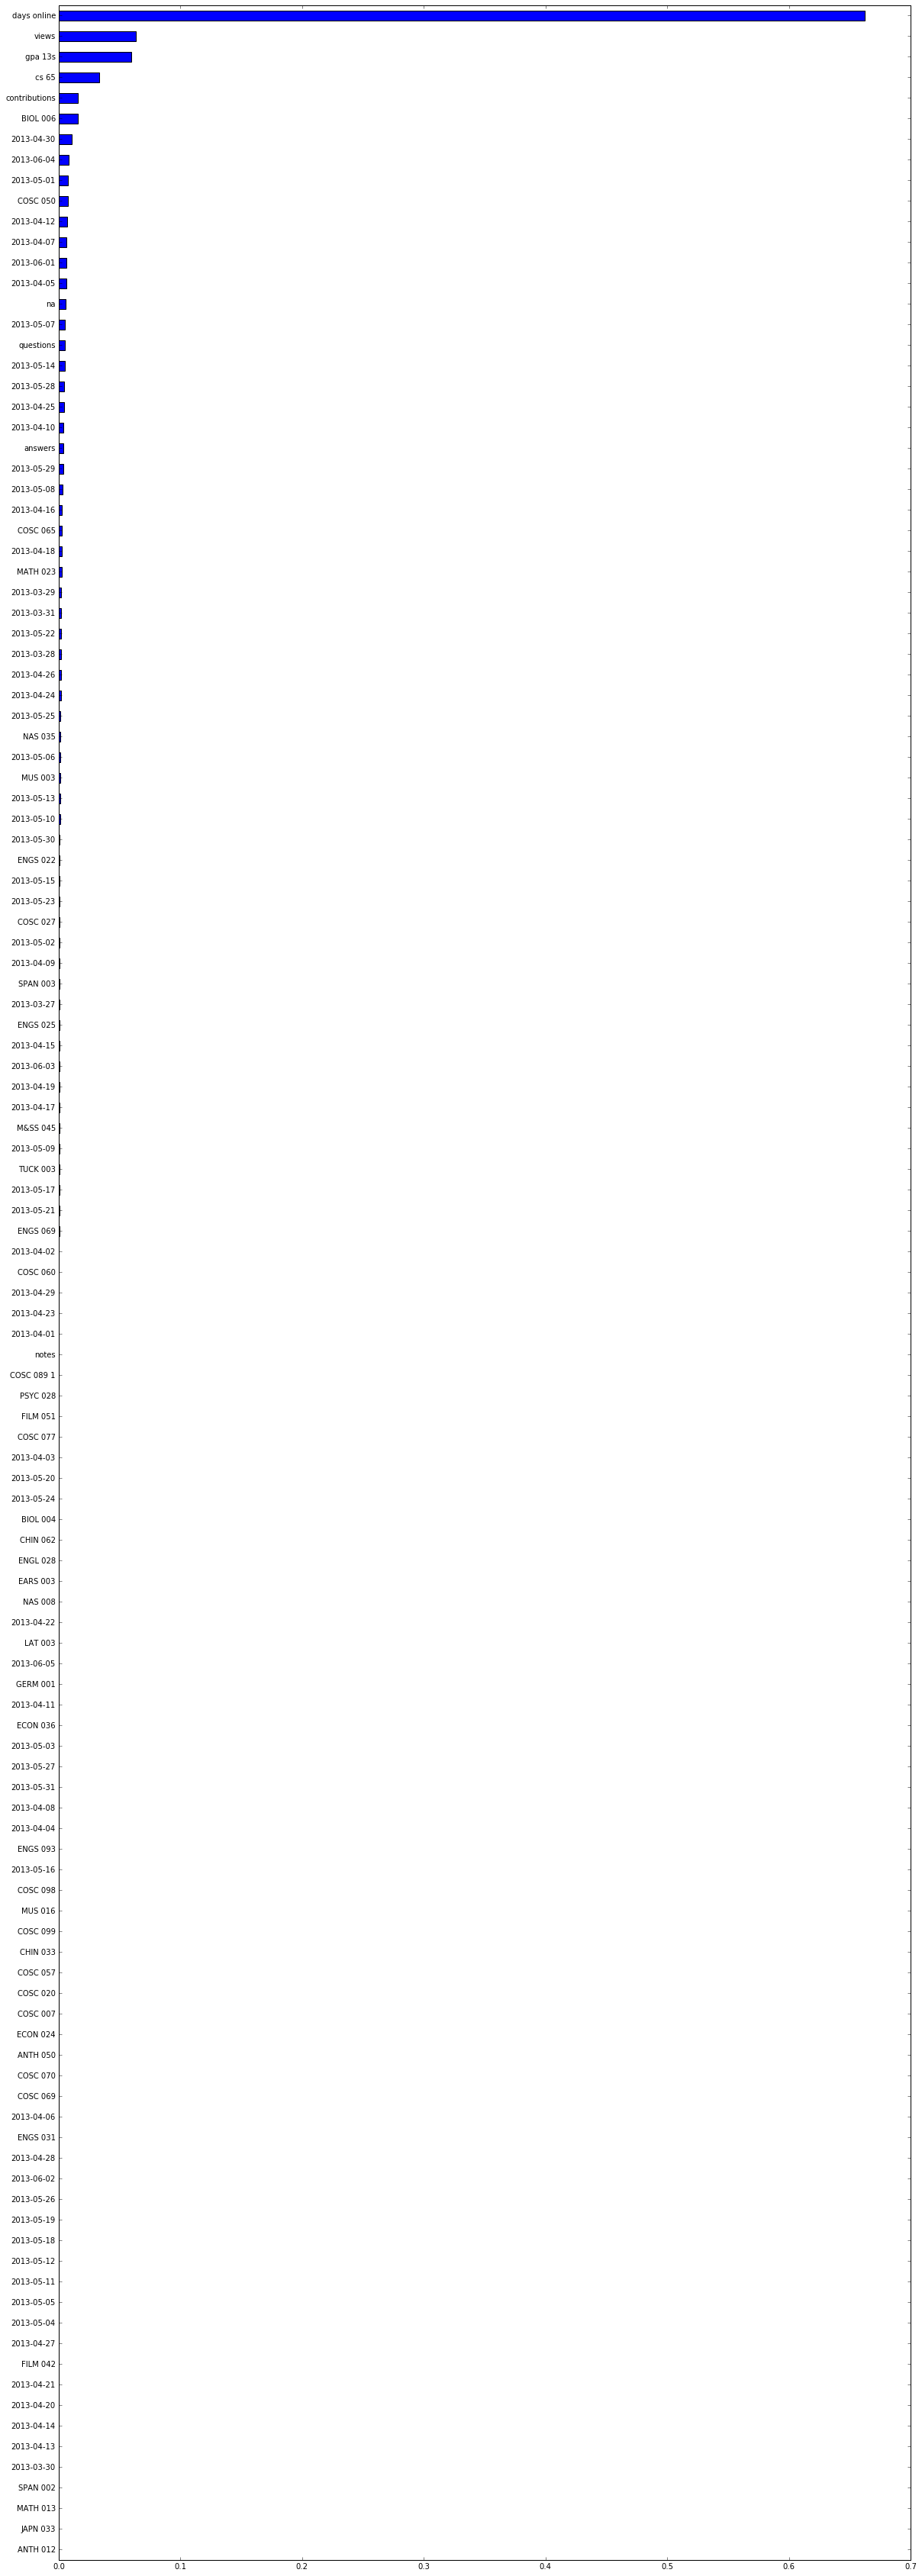

In [152]:
# Chart to show importance of variables
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances.sort_values(inplace=True)
feature_importances.plot(kind="barh", figsize=(20,60));

### It appears that the number of days spent in the LMS is a really good predictor of a students GPA

30 trees
Mean accuracy  0.942870774661

50 trees
Mean accuracy  0.938122309634

100 trees
Mean accuracy  0.930483138442

200 trees
Mean accuracy  0.940575831794

300 trees
Mean accuracy  0.943395075525

400 trees
Mean accuracy  0.942877599296

500 trees
Mean accuracy  0.940727443318

1000 trees
Mean accuracy  0.938213602774

2000 trees
Mean accuracy  0.932163285303



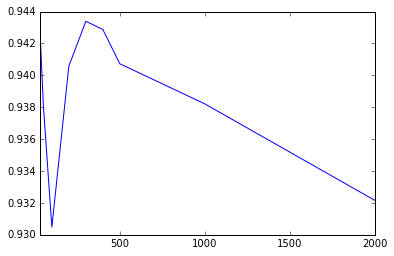

In [122]:
# Fine-tune model
# n_estimator tuning
results = []
n_estimator_options = [30, 50, 100, 200, 300, 400, 500, 1000, 2000]

for trees in n_estimator_options:
    model = RandomForestRegressor(trees, oob_score=True, n_jobs=-1, random_state=42)
    model.fit(X_train, y_train)
    print trees, "trees"
    scr = model.score(X_train,y_train)
    print "Mean accuracy ", scr
    results.append(scr)
    print ""
    
pd.Series(results, n_estimator_options).plot();

#### 300 estimators seems to be the best number of trees in the forest

auto option
Mean accuracy:  0.943395075525

None option
Mean accuracy:  0.943395075525

sqrt option
Mean accuracy:  0.930957399144

log2 option
Mean accuracy:  0.92847847624

0.9 option
Mean accuracy:  0.944140067855

0.2 option
Mean accuracy:  0.935939894977



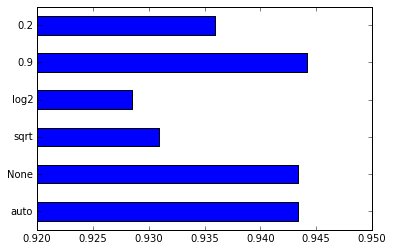

In [126]:
# max_feature tuning
results = []
max_features_options = ["auto", None, "sqrt", "log2", 0.9, 0.2]

for max_features in max_features_options:
    model = RandomForestRegressor(n_estimators=300, oob_score=True, n_jobs=-1, random_state=42, max_features=max_features)
    model.fit(X_train, y_train)
    print max_features, "option"
    scr = model.score(X_train, y_train)
    print "Mean accuracy: ", scr
    results.append(scr)
    print ""
    
pd.Series(results, max_features_options).plot(kind="barh", xlim=(.92,.95));

1 min samples
Mean accuracy:  0.943395075525

2 min samples
Mean accuracy:  0.895173280981

3 min samples
Mean accuracy:  0.837660013498

4 min samples
Mean accuracy:  0.76477108582

5 min samples
Mean accuracy:  0.731323031027

6 min samples
Mean accuracy:  0.716039743268

7 min samples
Mean accuracy:  0.646720366578

8 min samples
Mean accuracy:  0.311784131776

9 min samples
Mean accuracy:  0.0365779074863

10 min samples
Mean accuracy:  -5.56963695271e-05



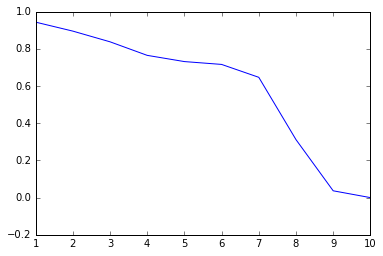

In [127]:
# tuning min_samples_leaf
results = []
min_samples_leaf_options = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

for min_samples in min_samples_leaf_options:
    model = RandomForestRegressor(n_estimators=300, 
                                  oob_score=True, 
                                  n_jobs=-1, 
                                  random_state=42, 
                                  max_features="auto", 
                                  min_samples_leaf=min_samples)
    model.fit(X_train, y_train)
    print min_samples, "min samples"
    scr = model.score(X_train, y_train)
    print "Mean accuracy: ", scr
    results.append(scr)
    print ""
    
pd.Series(results, min_samples_leaf_options).plot();

In [128]:
# Tuned model
model = RandomForestRegressor(n_estimators=300, 
                              oob_score=True, 
                              n_jobs=-1, 
                              random_state=42, 
                              max_features="auto", 
                              min_samples_leaf=1)
model.fit(X_train, y_train)
scr = model.score(X_train, y_train)
print "Mean accuracy: ", scr

Mean accuracy:  0.943395075525


In [141]:
#feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [142]:
X_scaled

array([[ 5.29150262, -0.18898224, -0.18898224, ...,  5.29150262,
        -1.94072391, -0.76819662],
       [-0.18898224, -0.18898224, -0.18898224, ..., -0.18898224,
         0.87861202,  0.49280538],
       [-0.18898224, -0.18898224, -0.18898224, ..., -0.18898224,
         0.24426143,  0.49280538],
       ..., 
       [-0.18898224, -0.18898224, -0.18898224, ..., -0.18898224,
         0.17377803,  0.49280538],
       [-0.18898224, -0.18898224, -0.18898224, ..., -0.18898224,
        -0.81298954,  0.49280538],
       [-0.18898224, -0.18898224, -0.18898224, ..., -0.18898224,
         0.31474483,  0.07247138]])

In [143]:
def find_k (X, k_range, sample_percent=1):
    """
    k_range: a list of possible k values
    X, the data we're clustering on
    """
    from sklearn.cluster import KMeans
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy.spatial.distance import cdist
    from sklearn.metrics import pairwise_distances

    N = X.shape[0]
    sampleSize = X.shape[0] * sample_percent

    if sampleSize > 0:
        index = np.arange(np.shape(X)[0])
        np.random.shuffle(index)
        X =  X[index, :]


    mean_distortions=[]
    for k in k_range:
        #cluster using k, then calculate the mean distortion (average distance to closest centroid)
        kmeans_model = KMeans(n_clusters=k, init='k-means++', n_jobs=-1).fit(X)
        mean_distortions.append(sum(np.min(pairwise_distances(X, kmeans_model.cluster_centers_,
                                                              metric='euclidean'),axis=1)) / X.shape[0])


    #visualize results
    plt.plot(k_range, mean_distortions)
    plt.xlabel("K Value")
    plt.ylabel("Mean Distortion")
    plt.title("Elbow Graph for Mean Distortion per K")
    plt.show()

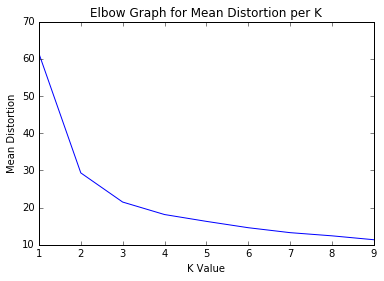

In [144]:
find_k(np.matrix(X), range(1,10),1)

In [145]:
kmeans_model = KMeans(n_clusters=3, random_state=42)
kmeans_model.fit(X_scaled)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=42, tol=0.0001,
    verbose=0)

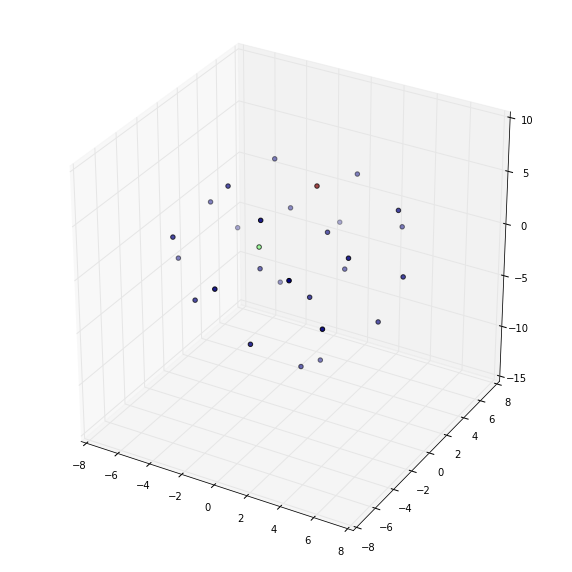

In [146]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

model = TSNE(n_components=3, learning_rate=12, random_state=10)
X_tsne = model.fit_transform(X) 
plt.figure(figsize=(10,10))
ax = plt.subplot(111, projection='3d')
ax.scatter(X_tsne[:, 0], X_tsne[:, 1],X_tsne[:,2], c=kmeans_model.labels_)